# Data

In [84]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [85]:
data = pd.read_csv("/home/Child_mortality_model/analysis_data.csv", index_col = [0])
data["child_mortality"] = data["child_mortality"].astype(int)
data["food_supply"] -= data["food_supply"].mean()
data["food_supply"] /= data["food_supply"].std()
data["med_beds"] -= data["med_beds"].mean()
data["med_beds"] /= data["med_beds"].std()
data["co2_emission"] -= data["co2_emission"].mean()
data["co2_emission"] /= data["co2_emission"].std()
data

,country,child_mortality,food_supply,med_beds,co2_emission
0,Afghanistan,60,-2.628914,-1.253230,-1.053513
1,Albania,8,0.827992,-0.268085,-0.809412
2,United Arab Emirates,7,0.547358,-0.856770,2.810071
3,Argentina,9,0.611138,0.628958,-0.294170
4,Armenia,12,-0.072589,0.332613,-0.754599
...,...,...,...,...,...
101,United States,6,1.792354,-0.288108,1.885356
102,Uzbekistan,20,-0.064936,0.128376,-0.607822
103,St. Vincent and the Grenadines,15,-0.189946,0.252520,-0.734790
104,Vietnam,20,0.006498,-0.360192,-0.689991


In [86]:
data["child_mortality"].mean()

12.754716981132075

In [87]:
data["child_mortality"].std()

13.412724108635635

In [88]:
data["food_supply"].mean()

-4.021940013736416e-16

In [89]:
data["food_supply"].std()

0.9999999999999999

In [90]:
data["med_beds"].mean()

6.074805229081045e-17

In [91]:
data["med_beds"].std()

1.0

In [92]:
data["co2_emission"].mean()

6.912709398609465e-17

In [93]:
data["co2_emission"].std()

1.0

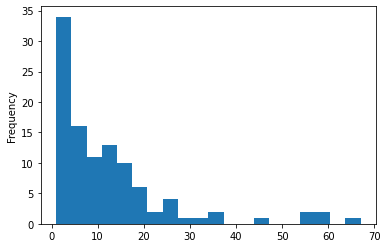

In [94]:
data['child_mortality'].plot.hist(bins=20)
plt.show()

# Prior

In [95]:
model_prior=CmdStanModel(stan_file='prior.stan')

sim=model_prior.sample(data={}, fixed_param=True, iter_sampling=1000, iter_warmup=0, chains = 1)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [96]:
df_prior = sim.draws_pd()
df_prior

,lp__,accept_stat__,alpha,lambda,child_mortality,food_supply_coef,co2_emission_coef,med_beds_coef,food_supply,co2_emission,med_beds
0,0.0,0.0,-0.080613,0.944715,2.0,0.258326,0.182610,0.248063,0.345689,0.153612,-0.377367
1,0.0,0.0,2.225200,8.166570,5.0,0.120589,0.283974,0.167070,0.695345,-0.229054,-0.861672
2,0.0,0.0,1.427260,2.993510,4.0,0.262250,0.062166,0.369006,-0.904742,-1.818430,0.052850
3,0.0,0.0,2.332860,11.073400,13.0,0.342954,0.180152,0.107002,-0.175174,-0.432719,1.959960
4,0.0,0.0,1.535420,12.724000,16.0,0.001406,0.141695,0.382349,0.611672,0.256319,2.539290
...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,1.843000,6.091140,8.0,0.013066,0.032776,0.090461,0.036588,0.417338,-0.556229
996,0.0,0.0,2.278870,11.151500,7.0,0.294411,0.442352,0.297301,0.961766,-0.636000,0.440261
997,0.0,0.0,2.925110,10.720800,14.0,0.442039,0.187063,0.124603,-0.568784,-0.890067,-1.083490
998,0.0,0.0,2.468160,11.268200,9.0,0.162592,0.243410,0.114477,-1.428490,0.191513,1.218350


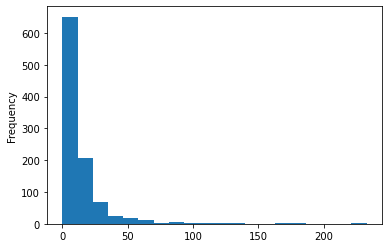

In [97]:
df_prior['child_mortality'].plot.hist(bins=20)
plt.show()

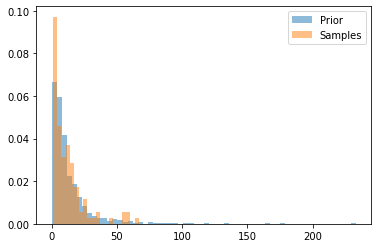

In [98]:
fig, ax = plt.subplots()
ax.hist(df_prior['child_mortality'], bins=60, alpha=0.5, density=True, label='Prior')
ax.hist(data["child_mortality"], bins=20, alpha=0.5, density=True, label='Samples')
ax.legend()
plt.show()

In [99]:
abs(df_prior['child_mortality'].mean() - data['child_mortality'].mean())

0.46828301886792545

# Model fitting

In [100]:
model_1=CmdStanModel(stan_file='posterior_1.stan')

INFO:cmdstanpy:compiling stan file /home/Child_mortality_model/posterior_1.stan to exe file /home/Child_mortality_model/posterior_1
INFO:cmdstanpy:compiled model executable: /home/Child_mortality_model/posterior_1
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Child_mortality_model/posterior_1.hpp /home/Child_mortality_model/posterior_1.stan
Warning in '/home/Child_mortality_model/posterior_1.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/Child_mortality_model/posterior_1.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
 

In [101]:
fit_1=model_1.sample(data=dict(N=len(data), child_mortality=data.child_mortality.values, co2_emission=data.co2_emission.values, food_supply=data.food_supply.values, med_beds=data.med_beds.values), seed=20052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:01 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [102]:
df_fit_1 = fit_1.draws_pd()
df_fit_1

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,co2_emission_coef,food_supply_coef,...,predicted_child_mortality[97],predicted_child_mortality[98],predicted_child_mortality[99],predicted_child_mortality[100],predicted_child_mortality[101],predicted_child_mortality[102],predicted_child_mortality[103],predicted_child_mortality[104],predicted_child_mortality[105],predicted_child_mortality[106]
0,2386.67,0.827082,0.464002,3.0,7.0,0.0,-2381.15,2.33075,-0.095910,-0.467588,...,8.0,16.0,7.0,10.0,11.0,5.0,9.0,15.0,13.0,38.0
1,2384.82,0.792054,0.464002,3.0,7.0,0.0,-2383.52,2.31647,-0.089831,-0.450515,...,5.0,3.0,5.0,5.0,6.0,3.0,8.0,11.0,5.0,35.0
2,2383.20,0.885331,0.464002,3.0,7.0,0.0,-2381.07,2.28674,-0.103134,-0.528289,...,8.0,8.0,3.0,9.0,13.0,3.0,11.0,12.0,8.0,54.0
3,2382.50,0.854565,0.464002,2.0,3.0,0.0,-2380.20,2.28977,-0.077325,-0.498253,...,9.0,8.0,3.0,5.0,14.0,1.0,14.0,12.0,8.0,47.0
4,2385.11,1.000000,0.464002,2.0,3.0,0.0,-2382.49,2.30381,-0.104006,-0.497769,...,15.0,6.0,4.0,4.0,7.0,4.0,8.0,6.0,10.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2385.31,0.957917,0.571707,3.0,7.0,0.0,-2384.61,2.35387,-0.104798,-0.482315,...,8.0,11.0,2.0,9.0,15.0,3.0,10.0,13.0,12.0,57.0
3996,2386.38,1.000000,0.571707,3.0,7.0,0.0,-2384.55,2.32767,-0.063348,-0.474930,...,13.0,5.0,8.0,2.0,10.0,5.0,17.0,8.0,14.0,32.0
3997,2386.85,0.894896,0.571707,2.0,5.0,0.0,-2385.78,2.33005,-0.109743,-0.458166,...,7.0,10.0,3.0,6.0,13.0,4.0,10.0,16.0,19.0,49.0
3998,2386.10,0.773609,0.571707,2.0,3.0,0.0,-2384.92,2.35220,-0.127116,-0.450745,...,9.0,15.0,7.0,8.0,11.0,5.0,9.0,11.0,14.0,59.0


In [103]:
means = []
medians = []
stds = []
for i in range(1, 107):
    means.append(df_fit_1["predicted_child_mortality[" + str(i) + "]"].mean())
    stds.append(df_fit_1["predicted_child_mortality[" + str(i) + "]"].std())
    medians.append(df_fit_1["predicted_child_mortality[" + str(i) + "]"].median())

In [104]:
abs(np.array(means).mean() - data['child_mortality'].mean())

0.001653301886793912

# MODEL FITTING 2

In [105]:
model_2=CmdStanModel(stan_file='posterior_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [106]:
fit_2=model_2.sample(data=dict(N=len(data), child_mortality=data.child_mortality.values, co2_emission=data.co2_emission.values, food_supply=data.food_supply.values, med_beds=data.med_beds.values), seed=20052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)



chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 


INFO:cmdstanpy:CmdStan done processing.


In [107]:
df_fit_2 = fit_2.draws_pd()
df_fit_2

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,predicted_child_mortality[97],predicted_child_mortality[98],predicted_child_mortality[99],predicted_child_mortality[100],predicted_child_mortality[101],predicted_child_mortality[102],predicted_child_mortality[103],predicted_child_mortality[104],predicted_child_mortality[105],predicted_child_mortality[106]
0,2558.99,0.950548,0.201671,4.0,31.0,0.0,-2493.79,3.29117,1.68240,2.30841,...,7.0,17.0,5.0,8.0,10.0,10.0,14.0,8.0,12.0,70.0
1,2552.72,0.998671,0.201671,4.0,15.0,0.0,-2508.23,2.98938,2.49974,1.62381,...,18.0,16.0,20.0,13.0,7.0,7.0,25.0,17.0,28.0,44.0
2,2570.93,0.619864,0.201671,4.0,15.0,0.0,-2508.44,3.45321,2.13261,2.43774,...,11.0,13.0,10.0,9.0,7.0,5.0,18.0,10.0,11.0,49.0
3,2561.83,0.926600,0.201671,4.0,15.0,0.0,-2519.14,3.73070,2.37732,2.25603,...,12.0,24.0,12.0,4.0,6.0,2.0,15.0,12.0,10.0,53.0
4,2556.58,0.875874,0.201671,4.0,15.0,0.0,-2501.14,3.92601,2.08756,1.83555,...,35.0,11.0,11.0,3.0,6.0,4.0,18.0,18.0,7.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2570.44,0.922788,0.224842,4.0,15.0,0.0,-2523.62,3.28599,1.69770,2.14879,...,16.0,23.0,18.0,12.0,4.0,1.0,22.0,14.0,19.0,52.0
3996,2563.09,0.959980,0.224842,4.0,15.0,0.0,-2518.54,3.39924,2.00547,2.28613,...,12.0,6.0,8.0,9.0,4.0,3.0,29.0,17.0,23.0,47.0
3997,2560.40,0.958851,0.224842,4.0,15.0,0.0,-2514.75,3.39694,2.08298,2.00701,...,19.0,12.0,14.0,8.0,6.0,9.0,21.0,19.0,18.0,44.0
3998,2559.49,0.821883,0.224842,4.0,15.0,0.0,-2503.66,3.39855,2.61729,2.10212,...,15.0,15.0,11.0,10.0,8.0,12.0,18.0,22.0,16.0,49.0


In [108]:
means = []
stds = []
for i in range(1, 107):
    means.append(df_fit_2["predicted_child_mortality[" + str(i) + "]"].mean())

In [109]:
abs(np.array(means).mean() - data['child_mortality'].mean())

0.10915801886792487

# Model comparison

In [110]:
compare_model_loo = az.compare(
    {
        "fit_1": az.from_cmdstanpy(fit_1),
        "fit_2": az.from_cmdstanpy(fit_2)
    },
    ic="loo",
    scale="deviance"
)

In [111]:
compare_model_waic = az.compare(
    {
        "fit_1": az.from_cmdstanpy(fit_1),
        "fit_2": az.from_cmdstanpy(fit_2)
    },
    ic="waic",
    scale="deviance"
)

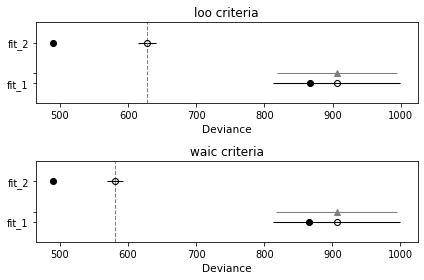

In [113]:
_, ax = plt.subplots(nrows=2, ncols=1)
az.plot_compare(compare_model_loo, insample_dev=True, ax=ax[0])
ax[0].set_title("loo criteria")
az.plot_compare(compare_model_waic, insample_dev=True, ax=ax[1])
ax[1].set_title("waic criteria")
plt.tight_layout()
plt.show()

In [115]:
print(compare_model_loo)

       rank         loo      p_loo       d_loo    weight         se  \
fit_2     0  627.279777  68.653124    0.000000  0.829824  13.299071   
fit_1     1  906.267919  20.017694  278.988142  0.170176  93.056177   

             dse  warning loo_scale  
fit_2   0.000000     True  deviance  
fit_1  87.689658     True  deviance  


In [116]:
print(compare_model_waic)

       rank        waic     p_waic      d_waic  weight         se        dse  \
fit_2     0  580.537610  45.282041    0.000000     1.0  11.468901   0.000000   
fit_1     1  906.519695  20.143582  325.982085     0.0  93.207484  88.621995   

       warning waic_scale  
fit_2     True   deviance  
fit_1     True   deviance  
